# About skills_detector.ipynb

This notebook detects skills in log files suchs as CVS.
This is a work in progress :)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages

## Let's detect use of different skills in 2 students
We are going to load the activity of 2 students: one who clearly uses a quantitative version of CVS in Beers sim and one who does not do CVS in Caps sim. We analyze their tables to detect use of CVS.
### First we load their log data

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


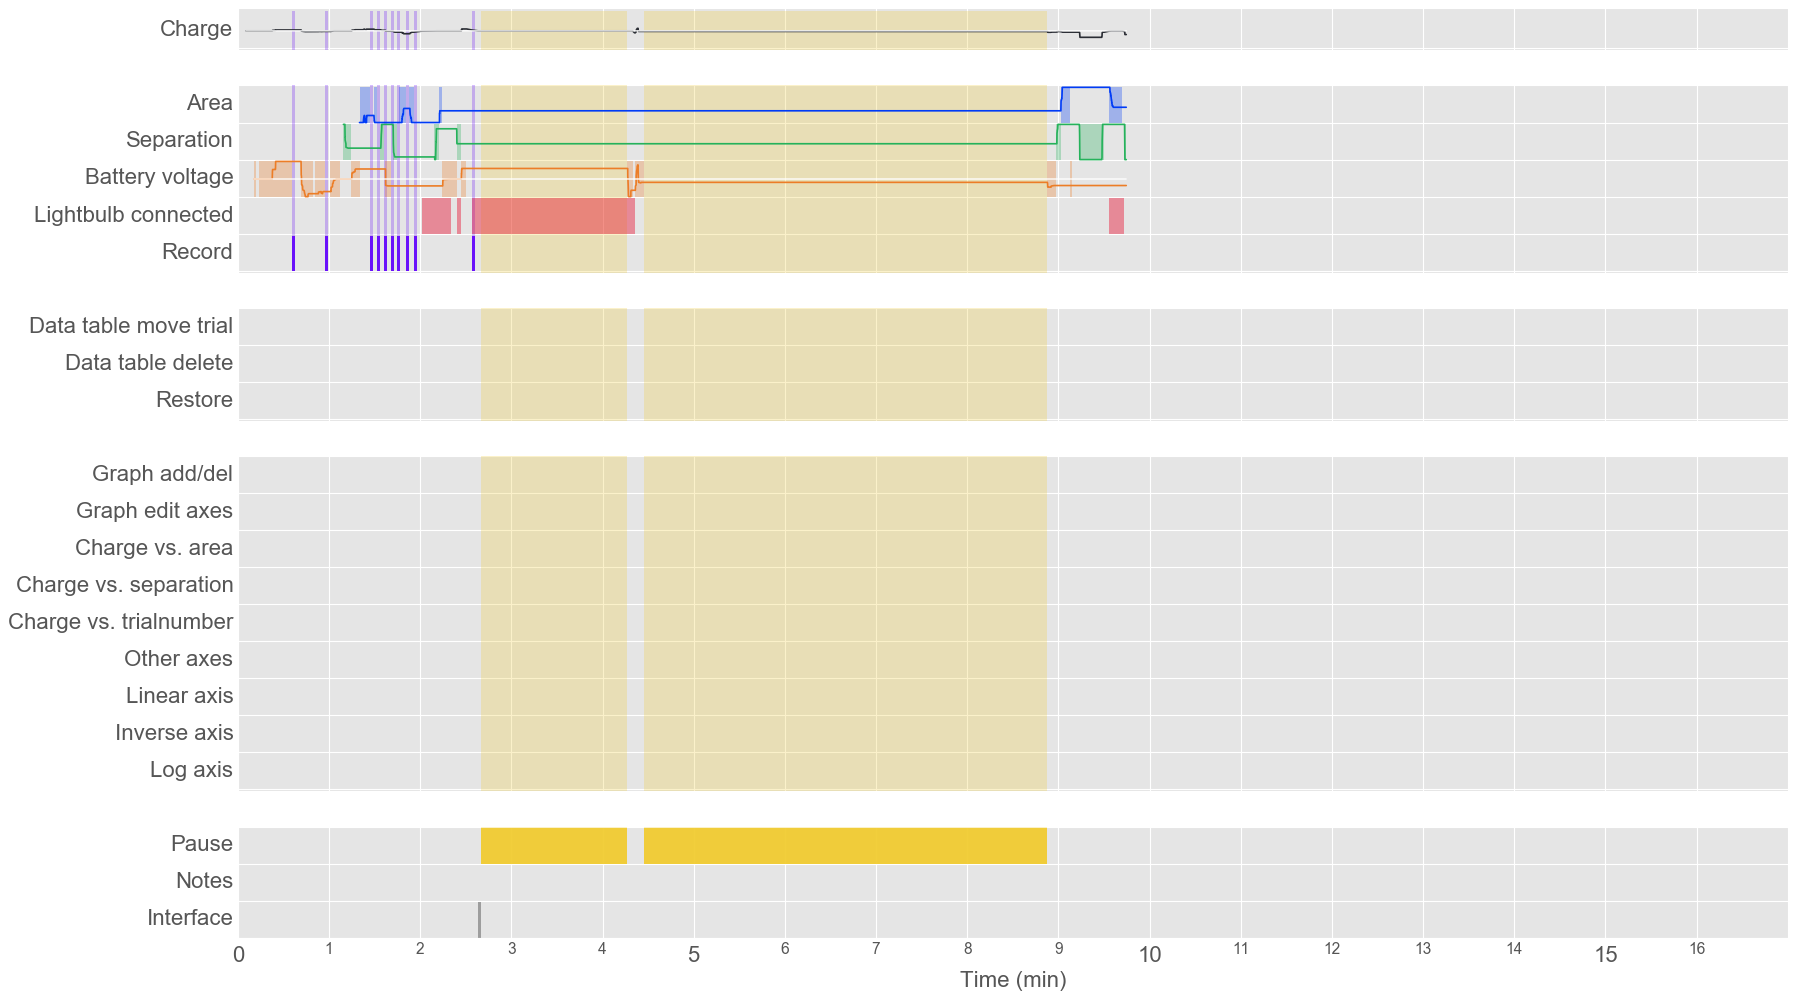

In [2]:
%aimport utils_timeline_viz
studentid = '17931169'
#main, cdw = 231
parsed_file = find_student_log_file("capacitor",studentid)#,date='2017-03-21_17.28.42')
df1 = prep_parsing_data(parsed_file)
plot(df1,to_plot_caps,family_name_to_code,function_to_use,colors)

359 359 359


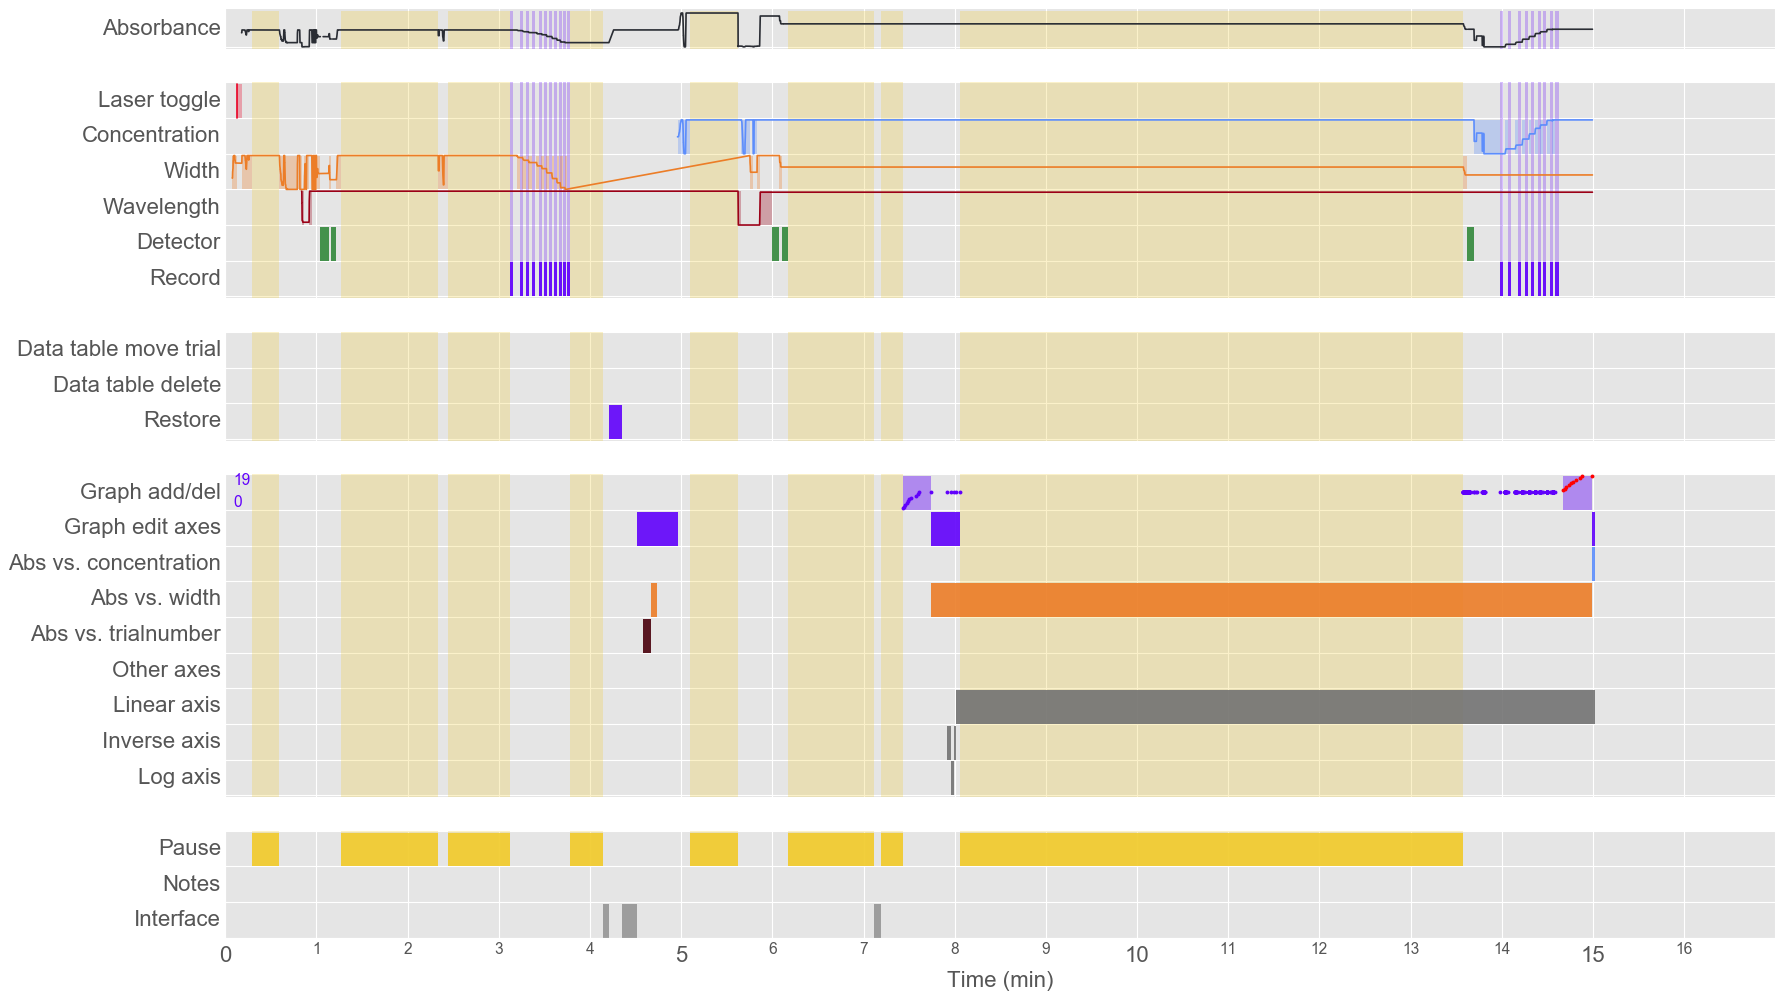

In [3]:
studentid = '16317166'
#main, cdw = 231
parsed_file = find_student_log_file("beers",studentid,date='2017-03-21_17.28.42')
df2 = prep_parsing_data(parsed_file)
plot(df2,to_plot_beers,family_name_to_code,function_to_use,colors)

## Quantitative CVS
### In table
First we extract all of their tables at all time points, analyze them for CVS and find the maximum number of values of a variable that was part of a control variable strategy instance.
For now, use of this skill relies on the following production rules (evaluated per variable):
* more than 2 successive records were done where only the variable was changed
* the outcome variable was different for both data points


In [4]:
def get_outcome_values(pts):
    outcomes = []
    for pt in pts:
        if "Charge" in pt.keys():
            outcomes.append(pt["Charge"])
        elif "Absorbance" in pt.keys():
            outcomes.append(pt["Absorbance"])
    return outcomes

def detect_cvs_quant_in_table(table):
    cvs_variable = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}

    variable_changed = None
    number_of_changes = 1
    prev_point = None
    #data points in order of trial number, which is synonomous with 
    #order of capture since when you move data points around in the table,
    #they keep the same trial number
    for datapoint in sorted(table.iterkeys()): 
        curr_point = table[datapoint]
        if prev_point:
            values_of_2_points = get_values_per_variable([prev_point,curr_point])
            confounded = pts_are_confounded(values_of_2_points)
            outcome1,outcome2 = get_outcome_values([prev_point,curr_point])
            #we check that only one variable is changed,
            #that the outcome values are different and that they are not null but floats
            if not confounded and outcome1!= outcome2 and isinstance(outcome1, float) and isinstance(outcome2, float):
                #find the variable being changed
                for v,vals in values_of_2_points.iteritems():
                    if len(vals) > 1:
                        new_var_changed = v
                #update the number of changes for that variable
                if variable_changed == None or new_var_changed == variable_changed:
                    number_of_changes += 1
                else:
                    number_of_changes = 2
                variable_changed = new_var_changed
                cvs_variable[variable_changed] = number_of_changes
            else:
                number_of_changes = 1
                variable_changed = None
        prev_point = curr_point.copy()
    return cvs_variable
            
            
            
def get_cvs_per_variable_in_table(df):
    tables = set(df['Table'])
    cvs_final = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}
    for i,t in enumerate(tables):
        table = read_table(t) #converts json string to dictionary
        cvs_final = {k:max(v,detect_cvs_quant_in_table(table)[k]) for k,v in cvs_final.iteritems()}
    return cvs_final

In [5]:
print get_cvs_per_variable_in_table(df1)
print get_cvs_per_variable_in_table(df2)

{'Battery voltage': 2, 'Area': 3, 'Width': 0, 'Separation': 2, 'Wavelength': 0, 'Concentration': 0}
{'Battery voltage': 0, 'Area': 0, 'Width': 11, 'Separation': 0, 'Wavelength': 0, 'Concentration': 9}


In [6]:
def detect_cvs_quant_in_graph(points):
    cvs_variable = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}

    values = get_values_per_variable(points)
    confounded = pts_are_confounded(values)
    if not confounded:
        #find the variable being changed
        for v,vals in values.iteritems():
            if len(vals) > 1:
                cvs_variable[v] = len(vals)
    return cvs_variable
            
            
            
def get_cvs_per_variable_in_graph(df):
    tables = set(df['Table'])
    cvs_final = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}
    for i,t in enumerate(tables):
        table = read_table(t) #converts json string to dictionary
        pts = get_pts(table,in_graph=True) #grab all points
#         print pts
        cvs_final = {k:max(v,detect_cvs_quant_in_graph(pts)[k]) for k,v in cvs_final.iteritems()}
#         print cvs_final
#         print '\n'
    return cvs_final

In [7]:
print get_cvs_per_variable_in_graph(df1)
print get_cvs_per_variable_in_graph(df2)

{'Battery voltage': 0, 'Area': 0, 'Width': 0, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
{'Battery voltage': 0, 'Area': 0, 'Width': 10, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}


## Let's run the detector on all students...
Since we don't yet have a metadata file to pull the right log data per student (and ingore student id that were test runs or unusable student data) were going to run the detector on all student ids have exactl one log file for each sims (~150).

In [8]:
from utils_read_parsing import *
def get_ids_with_exactly_one_of_each_logs():
    df_beers = get_latest_parsing_report('beers')
    df_caps = get_latest_parsing_report('capacitor')

    ids_beers = list(df_beers['studentid'].apply(str))
    ids_caps = list(df_caps['studentid'].apply(str))
    all_ids = ids_beers + ids_caps

    ids_by_count = {}
    for i in set(all_ids):
        count = all_ids.count(i)
        if count not in ids_by_count.keys():
            ids_by_count[count] = [i]
        else:
            ids_by_count[count].append(i)

    beers_only, caps_only, both_sims = [],[],[]
    for i in ids_by_count[2]:
        if i in ids_beers and i in ids_caps: both_sims.append(i)
    print "There are {0} ids with exactly one log for each sim".format(len(both_sims))
    return both_sims

In [9]:
ids = get_ids_with_exactly_one_of_each_logs()

Captured beers parsing report that was parsed on 2017-11-09_09.25.32
Captured capacitor parsing report that was parsed on 2017-11-08_14.55.27
There are 151 ids with exactly one log for each sim


In [10]:
table_cvs_df = pd.DataFrame({'student id':ids, 'Battery voltage':0, 'Area':0, 'Separation':0,'Wavelength':0,'Width':0, 'Concentration':0})
table_cvs_df =  table_cvs_df.set_index('student id')

for i,studentid in enumerate(ids):
    for sim in ['beers','capacitor']:
        parsed_file = find_student_log_file(sim,studentid)
        df = prep_parsing_data(parsed_file)
        if not df.empty:
            try:
                cvs = get_cvs_per_variable_in_table(df)
                for var, n_samples in cvs.iteritems():
                    if n_samples >0:
                        table_cvs_df.loc[studentid][var] = n_samples
            except:
                pass

The parsed file has no user events, only model events. No dataframe prepared.
The parsed file has no user events, only model events. No dataframe prepared.


In [11]:
# table_cvs_df['sum'] =table_cvs_df.sum(axis=1)
# table_cvs_df[table_cvs_df['sum']>0]

In [12]:
table_cvs_df.head()

,Area,Battery voltage,Concentration,Separation,Wavelength,Width
student id,,,,,,
14055131,3,2,4,3,5,4
15554169,0,0,2,0,4,2
14302168,5,7,6,6,6,9
19089138,0,2,0,2,0,0
13310139,4,9,0,8,0,0


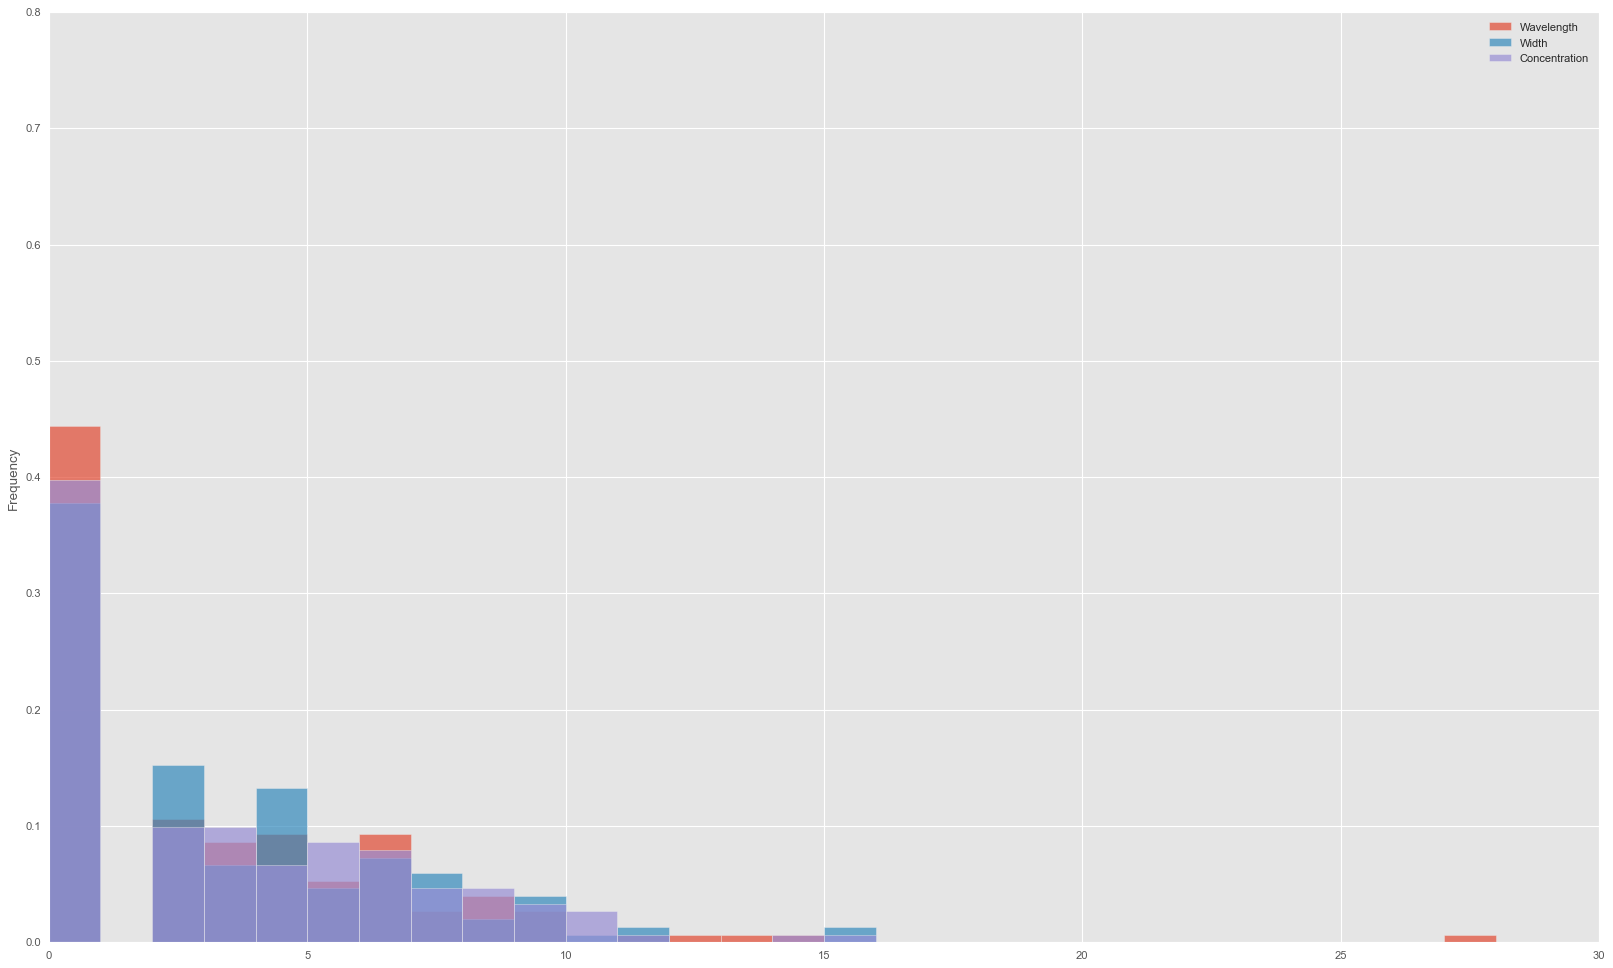

In [13]:
plt = table_cvs_df[['Wavelength','Width','Concentration']].plot.hist(alpha=0.7,bins=range(30),normed =True,ylim=(0,0.8))

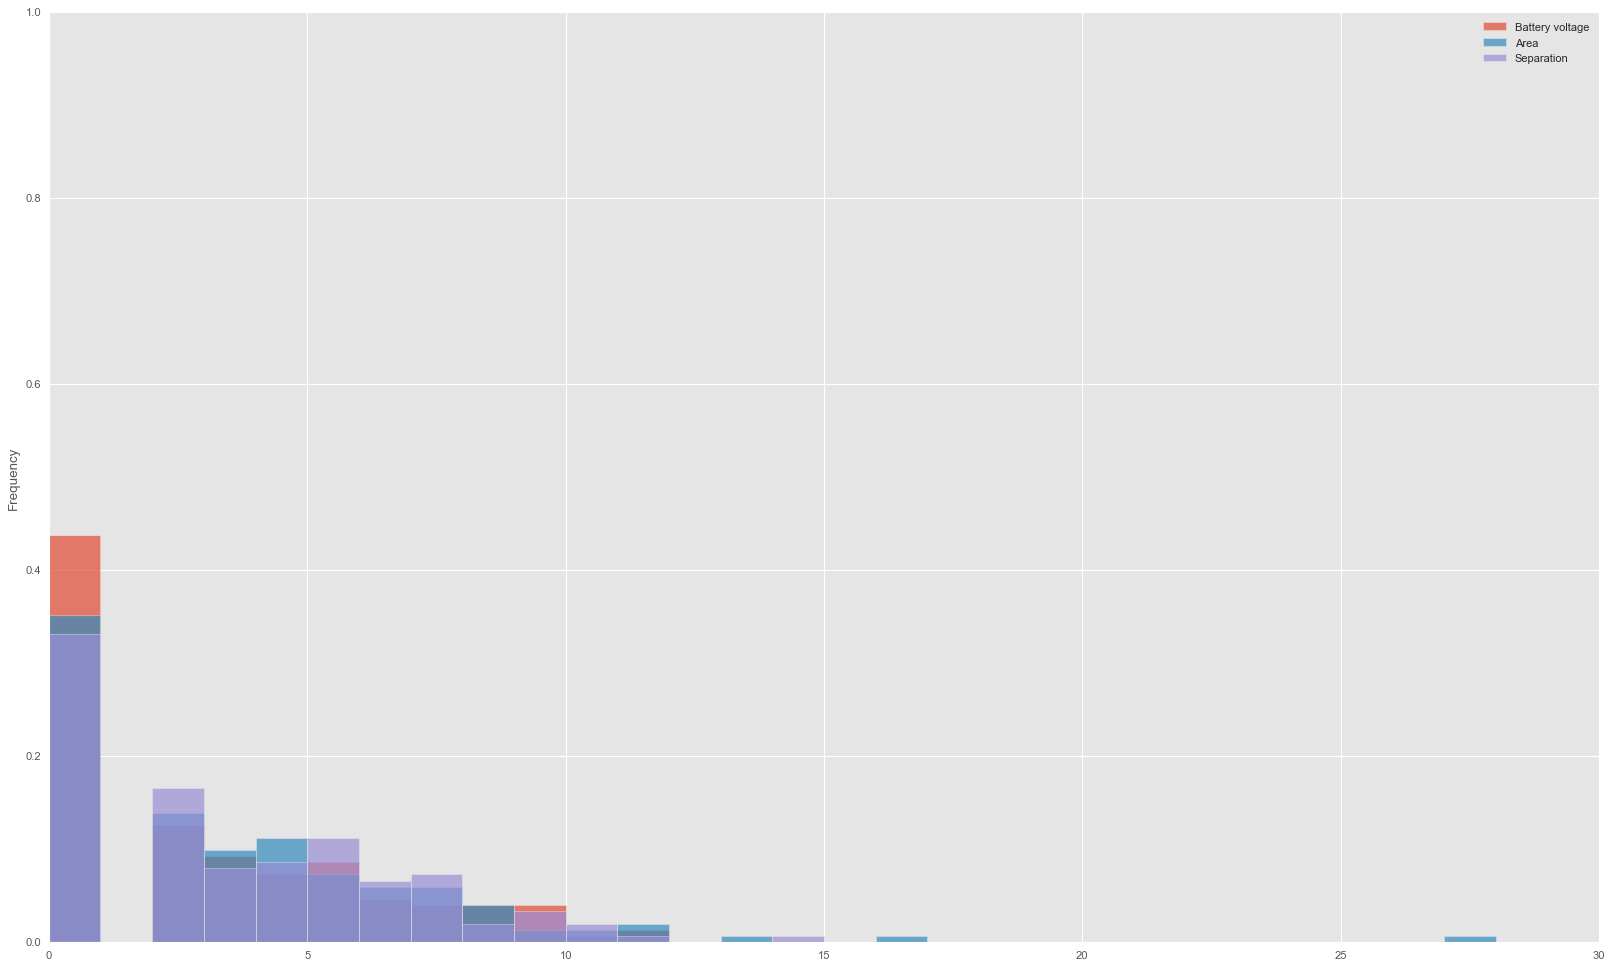

In [14]:
plt = table_cvs_df[['Battery voltage','Area','Separation']].plot.hist(alpha=0.7,bins=range(30),normed =True,ylim=(0,1))

In [15]:
graph_cvs_df = pd.DataFrame({'student id':ids, 'Battery voltage':0, 'Area':0, 'Separation':0,'Wavelength':0,'Width':0, 'Concentration':0})
graph_cvs_df =  graph_cvs_df.set_index('student id')

for i,studentid in enumerate(ids):
    for sim in ['beers','capacitor']:
        parsed_file = find_student_log_file(sim,studentid)
        df = prep_parsing_data(parsed_file)
        if not df.empty:
            try:
                cvs = get_cvs_per_variable_in_graph(df)
                for var, n_samples in cvs.iteritems():
                    if n_samples >0:
                        graph_cvs_df.loc[studentid][var] = n_samples
            except:
                pass

The parsed file has no user events, only model events. No dataframe prepared.
The parsed file has no user events, only model events. No dataframe prepared.


In [16]:
graph_cvs_df.head()

,Area,Battery voltage,Concentration,Separation,Wavelength,Width
student id,,,,,,
14055131,3,2,4,3,0,2
15554169,0,0,5,0,8,4
14302168,7,7,5,5,9,8
19089138,0,0,0,0,0,0
13310139,4,0,0,7,0,0


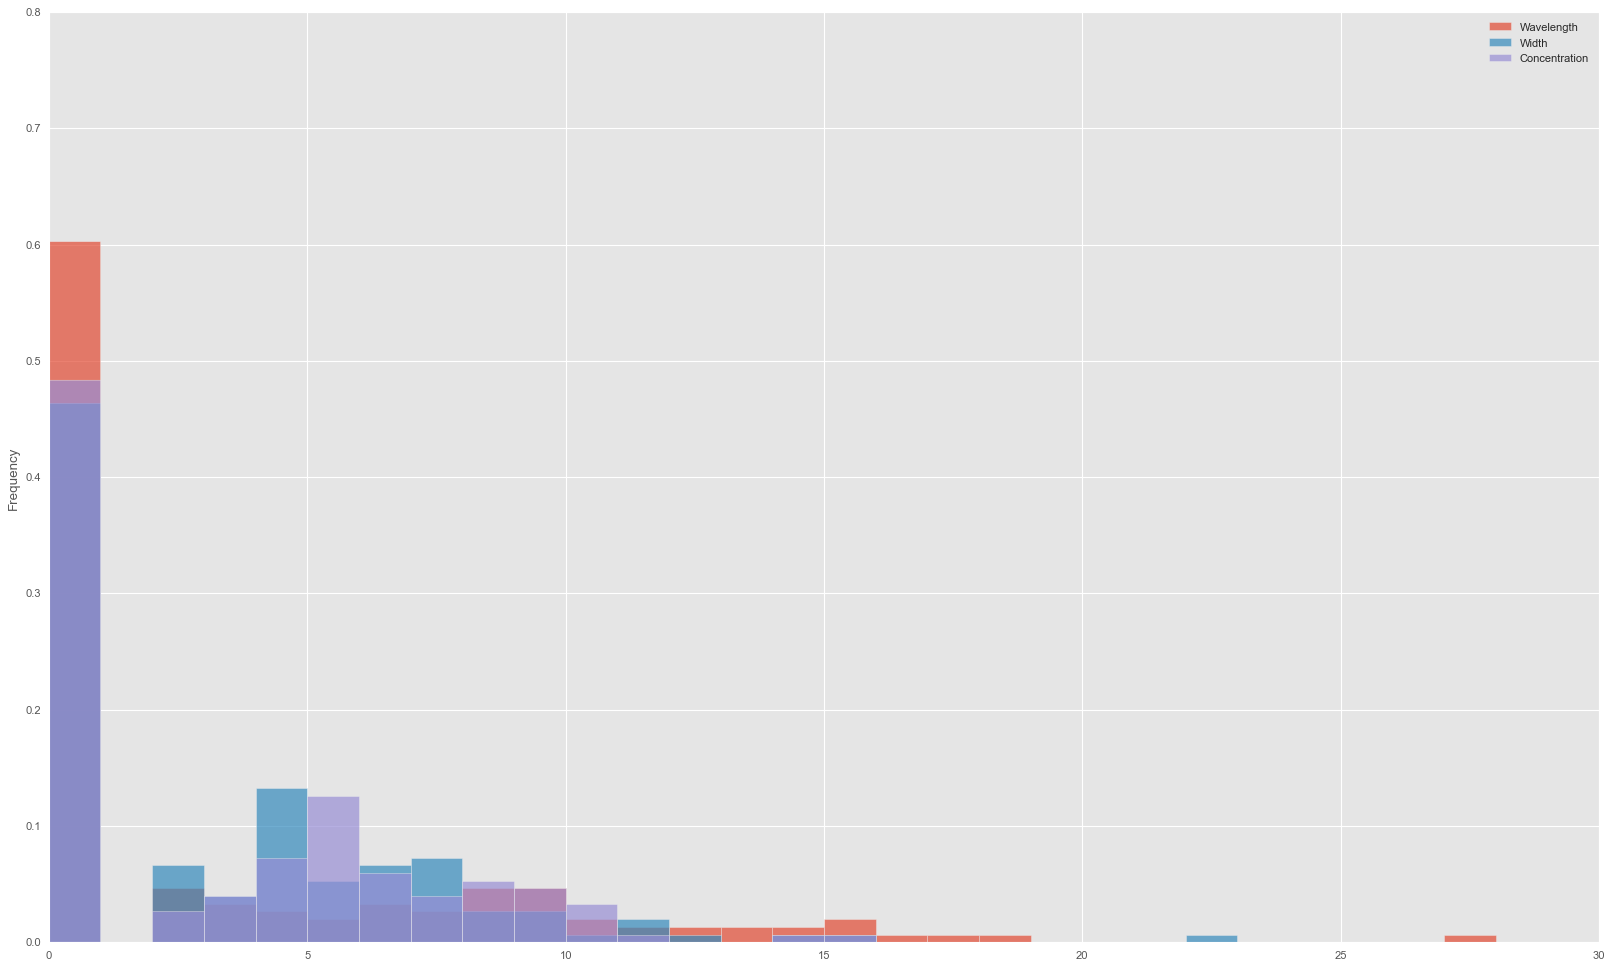

In [17]:
plt = graph_cvs_df[['Wavelength','Width','Concentration']].plot.hist(alpha=0.7,bins=range(30),normed =True,ylim=(0,0.8))

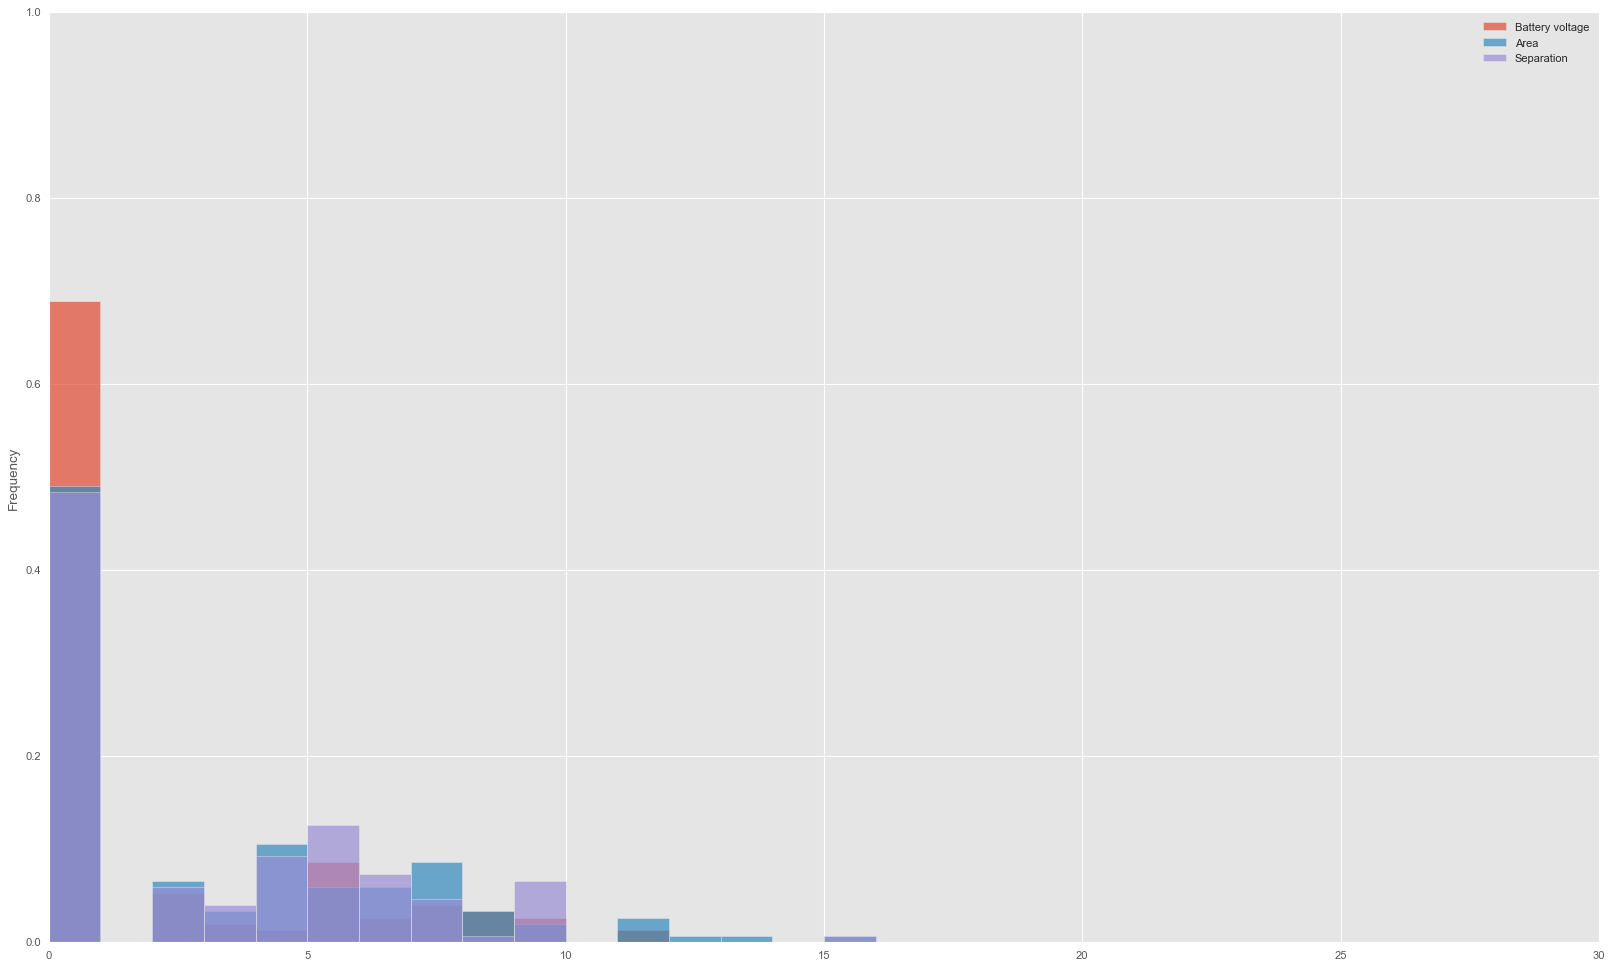

In [18]:
plt = graph_cvs_df[['Battery voltage','Area','Separation']].plot.hist(alpha=0.7,bins=range(30),normed =True,ylim=(0,1))